## Synthetic Dataset Develope Flow

In [1]:
import json
import glob
from PIL import Image
import cv2
import numpy as np
import matplotlib.pyplot as plt

def synthetic_preprocess(language,id):
    data_path = '/data/ephemeral/home/code/data/'
    json_path = data_path + language +'_receipt/ufo/' + 'relabel' + '.json'
    image_files = glob.glob(data_path + language +'_receipt/img/' + 'train' + '/*.jpg')

    img = cv2.imread(image_files[id])
    with open(json_path, 'r') as json_file:
        jf = json.load(json_file)
    image_name = image_files[id].split('/')[-1]
    points_list = []
    for word in jf['images'][image_name]['words'].keys():
        points = jf['images'][image_name]['words'][word]['points']
        points_list.append(points)

    x_lim = np.clip(np.array(points_list).reshape(-1,2)[:,0],a_min=0,a_max=img.shape[1])
    y_lim = np.clip(np.array(points_list).reshape(-1,2)[:,1],a_min=0,a_max=img.shape[0])

    xy_lim = np.stack([x_lim,y_lim],axis=1)
    poly_list = xy_lim.reshape(-1,4,2)

    x2 = xy_lim.max(axis=0)[0]
    y2 = xy_lim.max(axis=0)[1]
    x1 = xy_lim.min(axis=0)[0]
    y1 = xy_lim.min(axis=0)[1]

    image_json = jf['images'][image_name]
    return img, poly_list, [x1,y1,x2,y2], image_json

img_background = synthetic_preprocess(language='chinese', id=1)

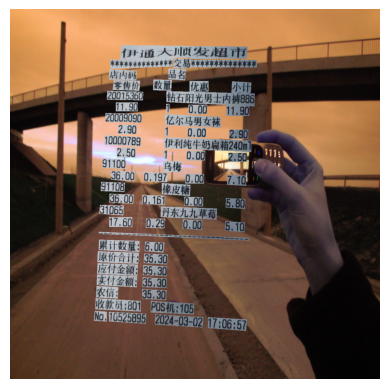

In [2]:
# 외부 이미지와의 결합
img1, points_list1, receipt_point1, json1 = img_background

background_image = cv2.imread('/data/ephemeral/home/Image_created_with_a_mobile_phone.png')
background_image = cv2.resize(background_image,(img1.shape[1],img1.shape[0]))
mask = np.zeros(img1.shape[:2])
img_mask = cv2.fillPoly(mask,np.int32(points_list1),1)
img_masks = img1 * np.expand_dims(img_mask,axis=-1) + background_image* (np.expand_dims(1-img_mask,axis=-1))
plt.axis('off')
plt.imshow(img_masks.astype('uint8'))

In [3]:
# background image와 text image의 글자 위치 matching

def matching_receipts(img_background,img_document,mask):
    img1, points_list1, receipt_point1,json1 = img_document
    img2, points_list2, receipt_point2,json2 = img_background

    x2_1 = receipt_point2[0] * img1.shape[1] / img2.shape[1]
    y2_1 = receipt_point2[1] * img1.shape[0] / img2.shape[0]
    x2_2 = receipt_point2[2] * img1.shape[1] / img2.shape[1]
    y2_2 = receipt_point2[3] * img1.shape[0] / img2.shape[0]

    x1_1 = receipt_point1[0]
    x1_2 = receipt_point1[2]
    y1_1 = receipt_point1[1]
    y1_2 = receipt_point1[3]

    forward_width = x1_2 - x1_1
    forward_height = y1_2 - y1_1

    back_width = x2_2 - x2_1
    back_height = y2_2 - y2_1

    x_var = np.array([[1,0]]*4)
    y_var = np.array([[0,1]]*4)

    if back_width - forward_width < 0 or back_height - forward_height < 0 :
        scale_factor = min(back_width/forward_width,back_height/forward_height)
        scaling_matrix = np.float32([[scale_factor,0,0],[0,scale_factor,0],[0,0,1]])

        rows, cols = img1.shape[:2]
        scaled_size = (int(cols * scale_factor), int(rows * scale_factor))
        img1 = cv2.warpPerspective(img1,scaling_matrix,(img1.shape[1],img1.shape[0]))
        mask = cv2.warpPerspective(mask,scaling_matrix,(img1.shape[1],img1.shape[0]))

        for i in json1['words']:
            json1['words'][i]['points'] = (np.array(json1['words'][i]['points']) * scale_factor).tolist()

        x1_1 = receipt_point1[0] * scale_factor
        x1_2 = receipt_point1[2] * scale_factor
        y1_1 = receipt_point1[1] * scale_factor
        y1_2 = receipt_point1[3] * scale_factor
    
    if  x2_1 - x1_1 > 0 or x1_2 - x2_2 > 0:
        move = x2_1 - x1_1
        translation_matrix = np.float32([[1,0,move],
                                        [0,1,0],
                                        [0,0,1]])
        img1 = cv2.warpPerspective(img1,translation_matrix,(img1.shape[1],img1.shape[0]))
        mask = cv2.warpPerspective(mask,translation_matrix,(img1.shape[1],img1.shape[0]))

        for i in json1['words']:
            json1['words'][i]['points'] = (np.array(json1['words'][i]['points']) + x_var * move).tolist()
        

    if  y2_1 - y1_1 > 0 or y1_2 - y2_2 > 0:
        move = y2_1 - y1_1
        translation_matrix = np.float32([[1,0,0],
                                        [0,1,move],
                                        [0,0,1]])
        img1 = cv2.warpPerspective(img1,translation_matrix,(img1.shape[1],img1.shape[0]))
        mask = cv2.warpPerspective(mask,translation_matrix,(img1.shape[1],img1.shape[0]))

        for i in json1['words']:
            json1['words'][i]['points'] = (np.array(json1['words'][i]['points']) + y_var * move).tolist()

    return img1, json1, mask

In [4]:
# 합성 영수증 생성 (type은 종횡비의 기준에 따라 합성할 글자 필터링)

def synthtic_receipts(background,receipt, type='all'):
    paper_image = background[0]
    receipt_image = receipt[0]

    x1 = background[2][0] * receipt_image.shape[1] / paper_image.shape[1]
    y1 = background[2][1] * receipt_image.shape[0] / paper_image.shape[0]
    x2 = background[2][2] * receipt_image.shape[1] / paper_image.shape[1]
    y2 = background[2][3] * receipt_image.shape[0] / paper_image.shape[0]

    
    receipt_mask = np.zeros(receipt_image.shape[:2])
    paper_mask = np.zeros(paper_image.shape[:2])

    if type == 'long':
        ratio = []
        jsons = {'words':{}}
        for i,j in enumerate(receipt[3]['words']):
            width = receipt[1][i][:,0].max() - receipt[1][i][:,0].min()
            height = receipt[1][i][:,1].max() - receipt[1][i][:,1].min()
            if width/height > 10:
                ratio.append(receipt[1][i])
                jsons['words'][j] = receipt[3]['words'][j]
        
        receipt[3]['words'] = jsons['words']
        img_mask = cv2.fillPoly(receipt_mask,np.int32(ratio),1).copy()
    else:
        img_mask = cv2.fillPoly(receipt_mask,np.int32(receipt[1]),1).copy()
    back_mask = cv2.fillPoly(paper_mask,np.int32(background[1]),1).copy()

    receipt_image, receipt_json, img_mask = matching_receipts(background, receipt, img_mask)

    paper_image = cv2.resize(paper_image,(receipt_image.shape[1],receipt_image.shape[0]))
    back_mask = cv2.resize(back_mask,(img_mask.shape[1],img_mask.shape[0]))

    receipt_image = cv2.cvtColor(receipt_image, cv2.COLOR_BGR2GRAY)
    receipt_image = cv2.merge([receipt_image]*3)

    img_masks = ((cv2.blur(paper_image,(int(paper_image.shape[0]/10),int(paper_image.shape[0]/10)))) * np.expand_dims(back_mask,axis=-1) + paper_image* (np.expand_dims(1-back_mask,axis=-1))) * np.expand_dims(1- img_mask,axis=-1) + receipt_image * np.expand_dims(img_mask,axis=-1)
    return img_masks, receipt_json

#시각화
def visualize_img(img):
    img = img.astype('uint8')
    plt.figure(figsize=(10, 10))
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2GRAY),cmap='gray')
    plt.axis('off')
    plt.show()

#Sharpening & Erode
def sharpening(image, strength):
    image = image.astype('uint8')
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    b = (1 - strength) / 8
    sharpening_kernel = np.array([[b, b, b],
                                  [b, strength, b],
                                  [b, b, b]])
    kernel = np.ones((3, 3), np.uint8)
    gray_image = cv2.erode(gray_image, kernel, iterations=1)
    gray_image = cv2.filter2D(gray_image, -1, sharpening_kernel)
    return gray_image

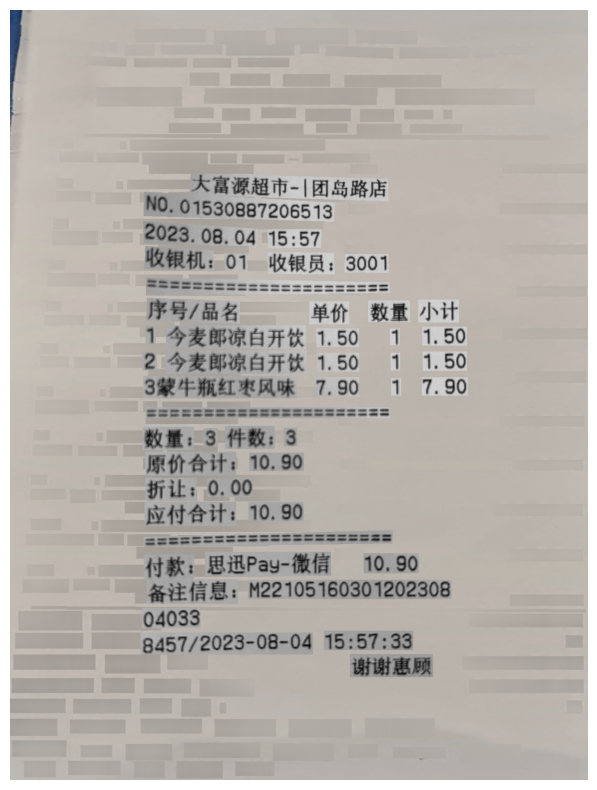

In [5]:
img_background = synthetic_preprocess(language='vietnamese', id=25)
img_document = synthetic_preprocess(language='chinese', id=25)

test_img,test_json = synthtic_receipts(img_background,img_document,type='all')
output1 = test_img.astype('uint8')
plt.figure(figsize=(10, 10))
plt.axis('off')
plt.imshow(output1)

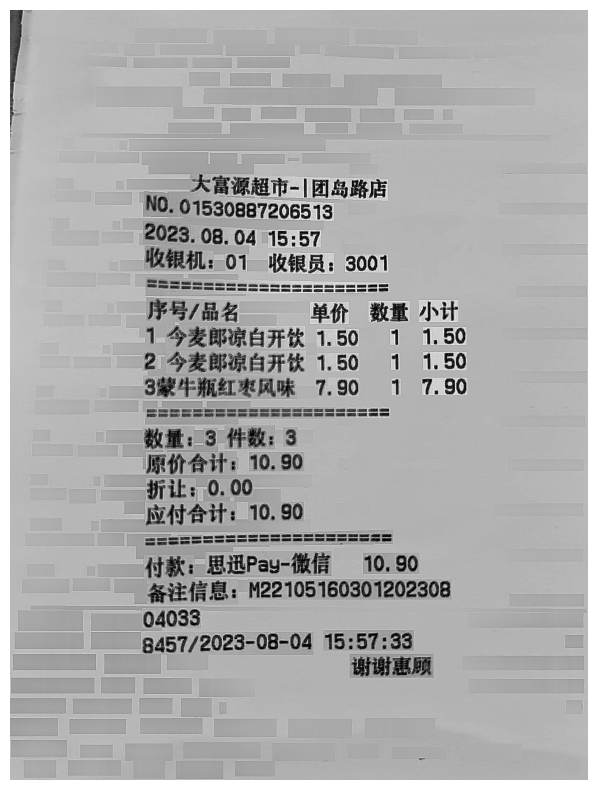

In [6]:
img_background = synthetic_preprocess(language='vietnamese', id=25)
img_document = synthetic_preprocess(language='chinese', id=25)

test_img,test_json = synthtic_receipts(img_background,img_document)
output1 = sharpening(test_img, strength=7)

output1 = output1.astype('uint8')
plt.figure(figsize=(10, 10))
plt.axis('off')
plt.imshow(output1,cmap='gray')

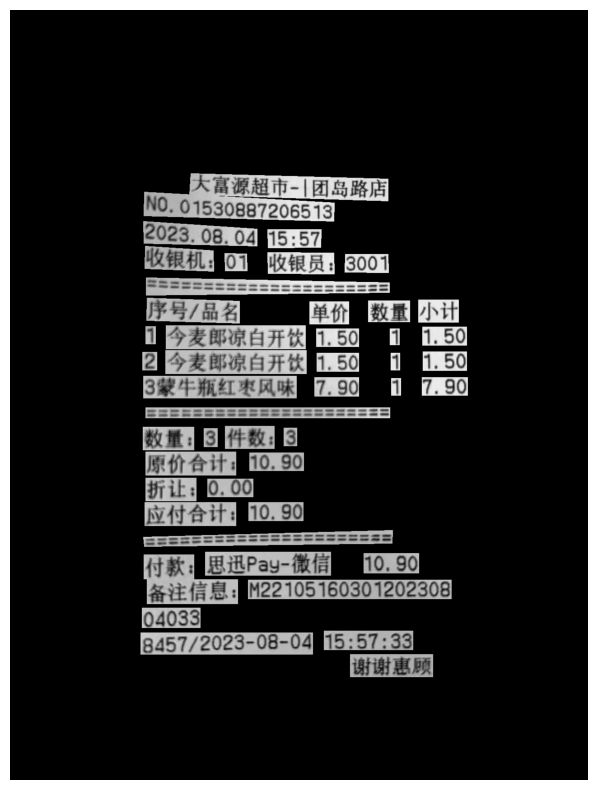

In [7]:
points_list = []
for word in test_json['words'].keys():
    points = test_json['words'][word]['points']
    points_list.append(points)

mask = np.zeros(test_img.shape[:2])
img_mask = cv2.fillPoly(mask,np.int32(points_list),1).copy()

visualize_img(test_img*np.expand_dims(img_mask,axis=-1))

## Random Style Augmentation

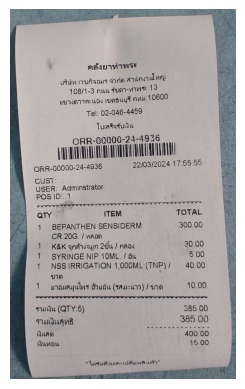

In [10]:
img_document = synthetic_preprocess(language='thai', id=20)
image = img_document[0]
plt.axis('off')
plt.imshow(image)

[HueSaturationValue(p=1.0, hue_shift_limit=(-20, 20), sat_shift_limit=(-30, 30), val_shift_limit=(-20, 20)), ColorJitter(p=1.0, brightness=(0.8, 1.0), contrast=(0.8, 1.0), saturation=(0.8, 1.0), hue=(-0.5, 0.5))]


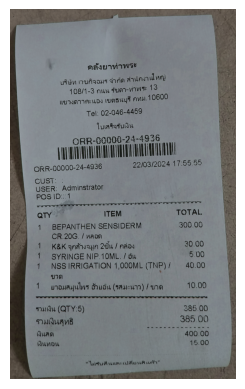

In [15]:
from RandAugment import RandAugment
import PIL
import matplotlib.pyplot as plt
import numpy as np

image = PIL.Image.open('/data/ephemeral/home/code/data/chinese_receipt/img/train/extractor.zh.in_house.appen_000008_page0001.jpg')
i=20
img_document = synthetic_preprocess(language='thai', id=i)

points = (img_document[1].reshape(-1,2)*0.999).tolist()
image = img_document[0]

# Add RandAugment with N, M(hyperparameter)
transform_train = RandAugment(2,8)
img = transform_train(image)
plt.axis('off')
plt.imshow(np.array(img))

